# Модели временных рядов для ML

---

Задачи на сегодняшний воркшоп:
 - построить модель временного ряда при помощи SARIMA
 - построить модель того же ряда при помощи бустинга по фичам

### Предсказание временного ряда посредством SARIMA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/hw_daily-temperatures.csv', index_col=['date'], parse_dates=True)

In [3]:
df.head()

,temp
date,
1987-10-18,10.1
1987-10-19,11.3
1987-10-20,10.4
1987-10-21,10.9
1987-10-22,9.2


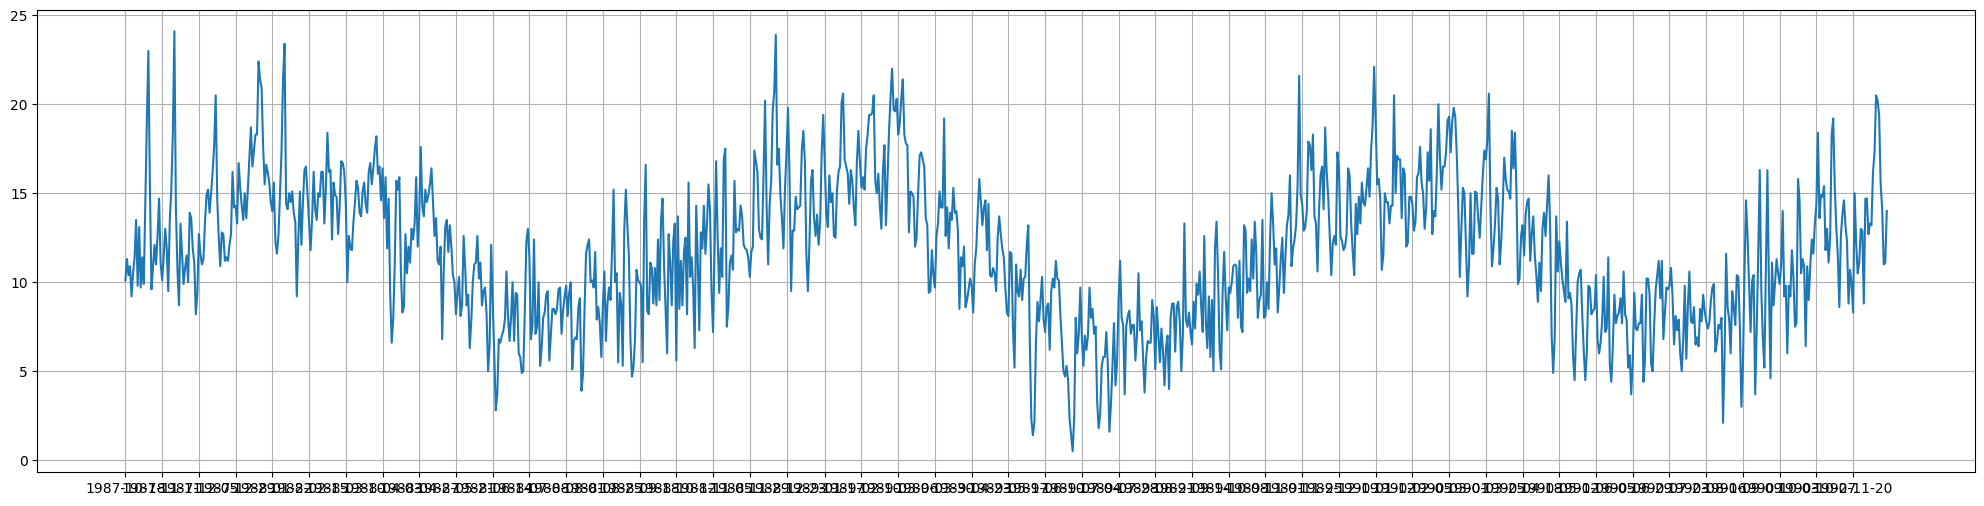

In [4]:
plt.figure(figsize=(25, 6))
plt.plot(df['temp'])
plt.xticks([df.index[i] for i in range(0, len(df), 24)])
plt.grid(True)
plt.show()

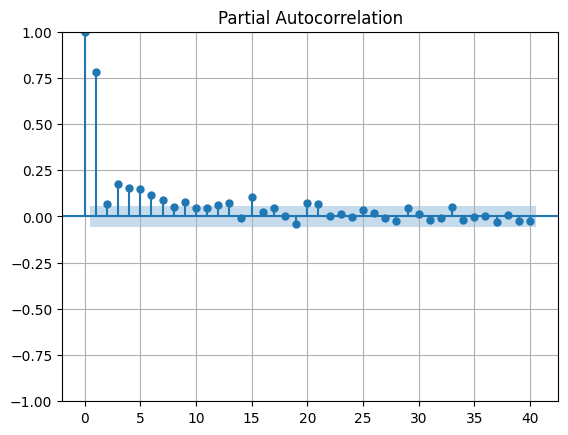

In [5]:
plot_pacf(df, lags=40)
plt.grid(True)
plt.show()

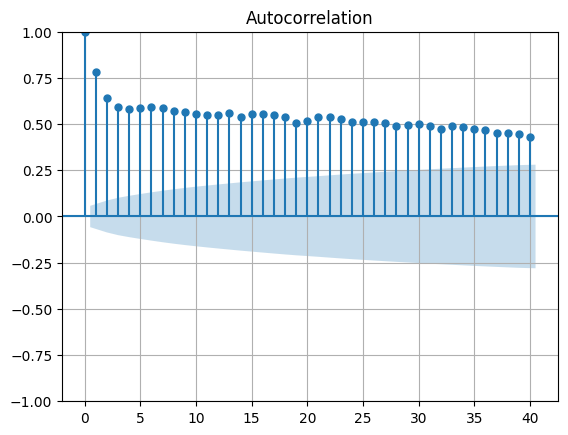

In [6]:
plot_acf(df, lags=40)
plt.grid(True)
plt.show()

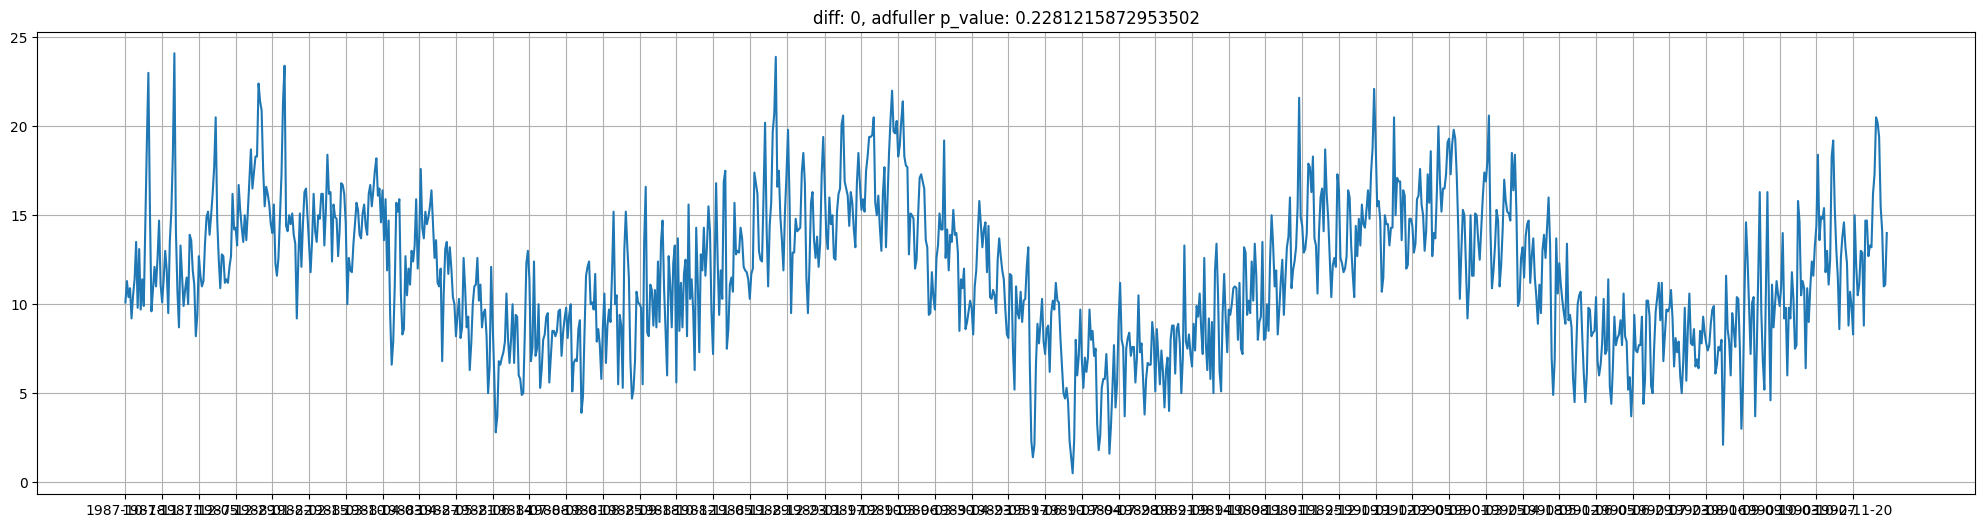

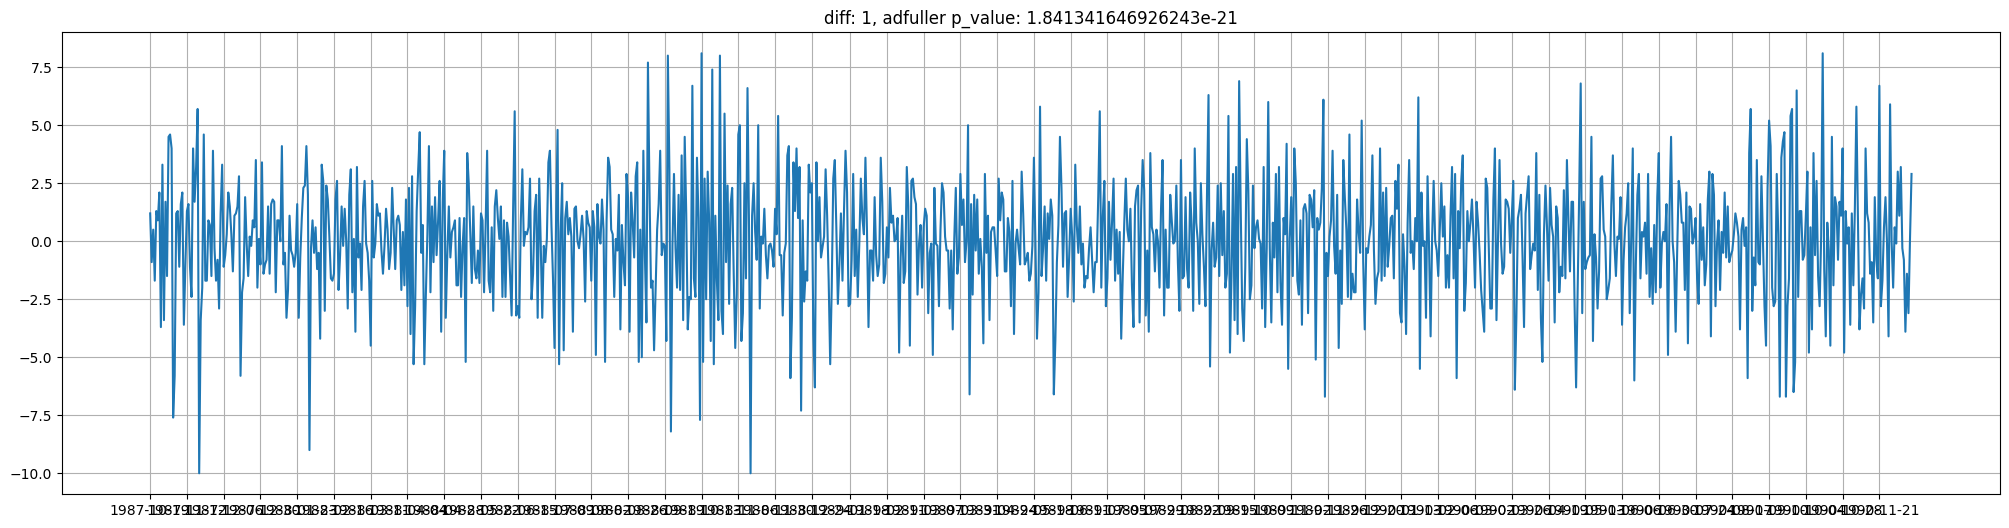

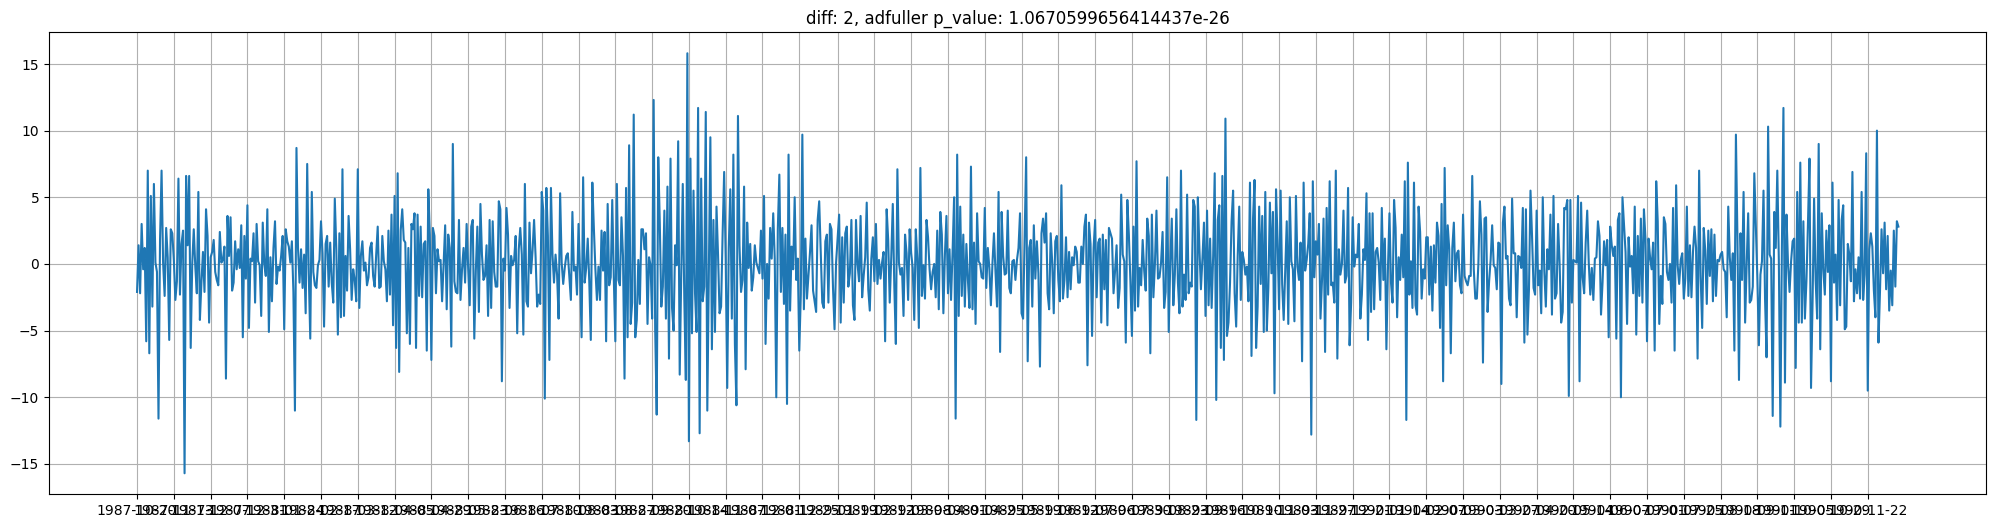

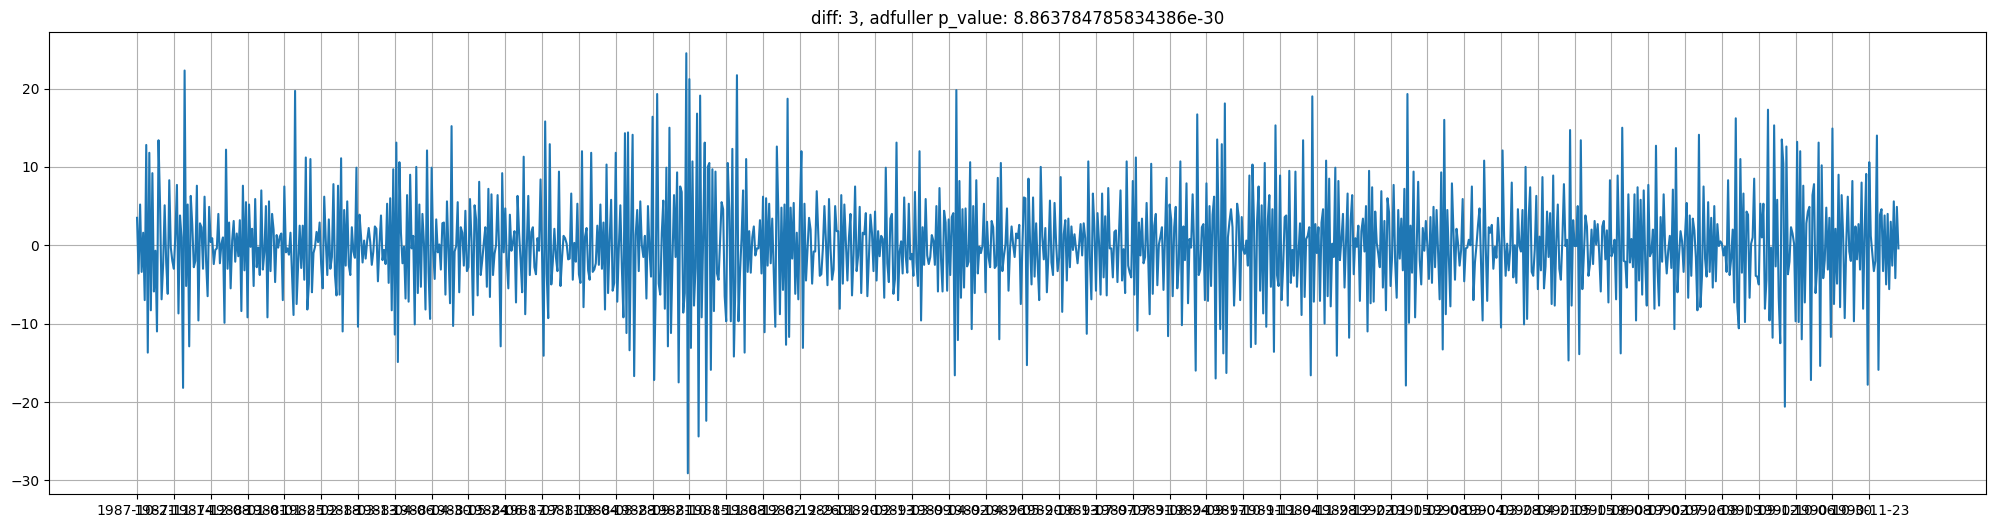

In [7]:
prev_diff = diff = df

plt.figure(figsize=(25, 6))
plt.plot(diff['temp'])
plt.xticks([diff.index[i] for i in range(0, len(diff), 24)])
plt.title(f'diff: 0, adfuller p_value: {adfuller(diff)[1]}')
plt.grid(True)
plt.show()


for i in range(3):
    prev_diff = diff
    diff = prev_diff - prev_diff.shift(1)
    diff = diff.dropna()
    plt.figure(figsize=(25, 6))
    plt.plot(diff['temp'])
    plt.xticks([diff.index[i] for i in range(0, len(diff), 24)])
    plt.title(f'diff: {i + 1}, adfuller p_value: {adfuller(diff)[1]}')
    plt.grid(True)
    plt.show()

In [8]:
model = SARIMAX(
    df['temp'], 
    order=(1, 1, 3),  # p, d, q
    seasonal_order=(2, 1, 2, 12)  # P, D, Q, s
).fit(disp=False)

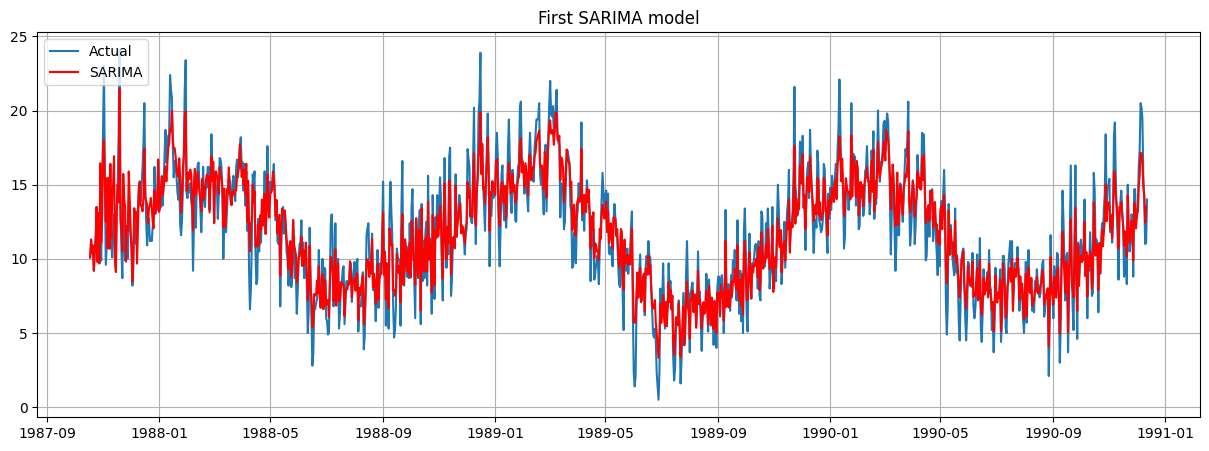

In [9]:
# надо сдвинуть на d = 1, т.к. разность съедает 1 шаг
df['naive_sarima'] = model.fittedvalues.shift(-1)

plt.figure(figsize=(15, 5))
plt.title("First SARIMA model")
plt.plot(df['temp'], label="Actual")
plt.plot(df['naive_sarima'], "r", label="SARIMA")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [12]:
model.mae, model.mse

(1.885867439042597, 5.801022128975744)

In [13]:
from itertools import product

ps = [1, 2, 3]
ds = [1]
qs = [2, 3, 4]
Ps = [1, 2, 3]
Ds = [1]
Qs = [2, 3, 4]
ss = [12]

parameters_list = list(product(ps, ds, qs, Ps, Ds, Qs, ss))
print(f'Всего наборов параметров: {len(parameters_list)}')

Всего наборов параметров: 81


In [14]:
from tqdm import tqdm

results = pd.DataFrame(columns=['p', 'd', 'q', 'P', 'D', 'Q', 's', 'mae', 'mse', 'aic'])

best_aic = 100500
best_model = None

for params in tqdm(parameters_list):
    try:
        model = SARIMAX(
            df['temp'], 
            order=params[:3],  # p, d, q
            seasonal_order=params[3:]  # P, D, Q, s
        ).fit(disp=False)
    except:
        continue

    if model.aic < best_aic:
        best_aic = model.aic
        best_model = model
    
    current_res = pd.DataFrame({
        'p': [params[0]],
        'd': [params[1]],
        'q': [params[2]],
        'P': [params[3]],
        'D': [params[4]],
        'Q': [params[5]],
        's': [params[6]],
        'mae': [model.mae],
        'mse': [model.mse],
        'aic': [model.aic]
    })
    results = pd.concat([results, current_res])

100%|██████████| 81/81 [49:36<00:00, 36.75s/it]


In [15]:
results = results.sort_values(by='aic')
results.head()

,p,d,q,P,D,Q,s,mae,mse,aic
0,1,1,2,3,1,4,12,1.880288,5.750441,5201.303833
0,1,1,3,3,1,4,12,1.875454,5.740061,5201.658267
0,3,1,2,3,1,4,12,1.876176,5.735091,5202.690068
0,2,1,3,3,1,4,12,1.875731,5.736654,5203.053201
0,1,1,2,2,1,3,12,1.883336,5.781160,5203.429484


Построим график с нашей лучшей моделью

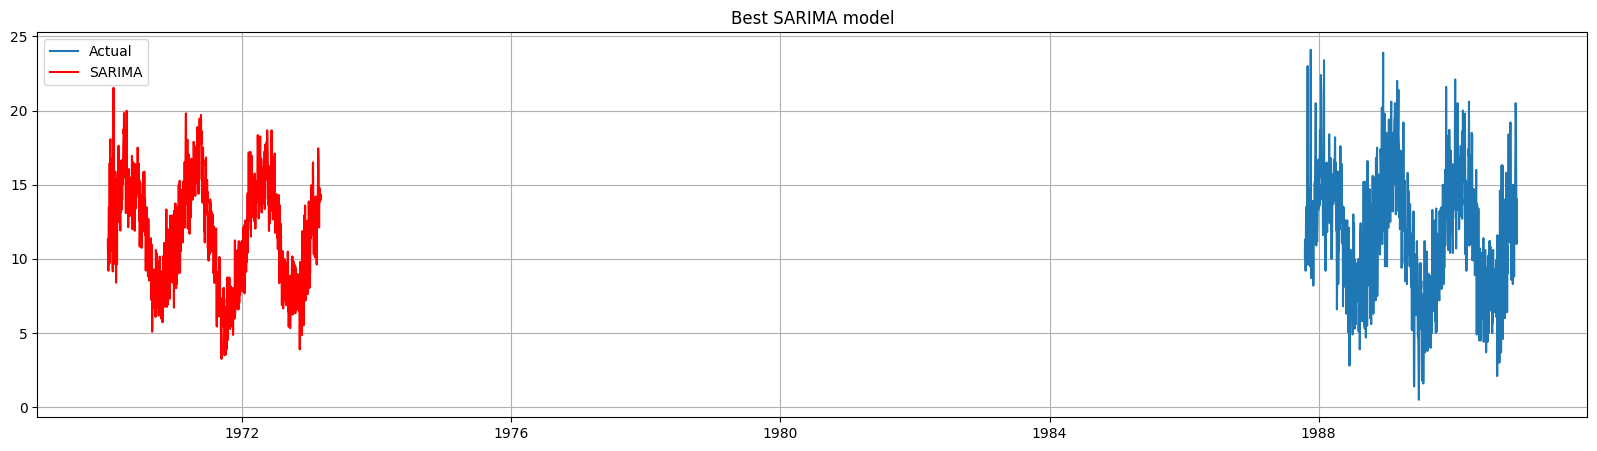

In [17]:
# сразу получим предсказание на несколько лет вперёд
prediction_period = 7 

predicted = best_model.predict(1, end=len(df) + prediction_period).shift(-1)

plt.figure(figsize=(20, 5))
plt.title("Best SARIMA model")
plt.plot(df['temp'], label="Actual")
plt.plot(predicted, "r", label="SARIMA")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

### Генерация фич и предсказание бустингом

In [23]:
# сразу добавим лаги
# предсказывать будем на 3 года вперёд, так что используем лаги 36-72

df_features = df.drop(columns=['naive_sarima']).copy()

for lag in range(36, 73, 1):
    df_features[f'lag_{lag}'] = df_features['temp'].shift(lag)

In [24]:
df_features.tail(12)

,temp,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,...,lag_63,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72
date,,,,,,,,,,,,,,,,,,,,,
1990-12-01,13.3,13.3,11.6,12.4,10.9,9.0,10.9,6.4,10.9,11.3,...,8.7,11.1,4.6,9.8,16.3,10.6,5.2,6.8,9.6,16.3
1990-12-02,13.2,14.4,13.3,11.6,12.4,10.9,9.0,10.9,6.4,10.9,...,10.0,8.7,11.1,4.6,9.8,16.3,10.6,5.2,6.8,9.6
1990-12-03,16.2,18.4,14.4,13.3,11.6,12.4,10.9,9.0,10.9,6.4,...,11.3,10.0,8.7,11.1,4.6,9.8,16.3,10.6,5.2,6.8
1990-12-04,17.3,13.6,18.4,14.4,13.3,11.6,12.4,10.9,9.0,10.9,...,10.5,11.3,10.0,8.7,11.1,4.6,9.8,16.3,10.6,5.2
1990-12-05,20.5,14.9,13.6,18.4,14.4,13.3,11.6,12.4,10.9,9.0,...,9.9,10.5,11.3,10.0,8.7,11.1,4.6,9.8,16.3,10.6
1990-12-06,20.2,14.8,14.9,13.6,18.4,14.4,13.3,11.6,12.4,10.9,...,11.0,9.9,10.5,11.3,10.0,8.7,11.1,4.6,9.8,16.3
1990-12-07,19.4,15.4,14.8,14.9,13.6,18.4,14.4,13.3,11.6,12.4,...,14.0,11.0,9.9,10.5,11.3,10.0,8.7,11.1,4.6,9.8
1990-12-08,15.5,11.8,15.4,14.8,14.9,13.6,18.4,14.4,13.3,11.6,...,9.2,14.0,11.0,9.9,10.5,11.3,10.0,8.7,11.1,4.6
1990-12-09,14.1,13.0,11.8,15.4,14.8,14.9,13.6,18.4,14.4,13.3,...,9.8,9.2,14.0,11.0,9.9,10.5,11.3,10.0,8.7,11.1


In [25]:
# добавим инфу о годе и месяце
# т.к. месяц - периодическая функция, сразу возьмём синус и косинус

from math import sin, cos, pi

df_features['year'] = [date.year for date in df.index]

df_features['month_sin'] = [sin(date.month * 2*pi / 12) for date in df.index]
df_features['month_cos'] = [cos(date.month * 2*pi / 12) for date in df.index]

In [26]:
# добавим данные о среднем и мин/макс значении за период 36-48 и 36-72 месяца назад
import numpy as np

df_features['mean_36_48'] = [df['temp'].iloc[i - 48:i - 36].mean() if i >= 48 else np.nan for i in range(len(df))]
df_features['mean_36_72'] = [df['temp'].iloc[i - 72:i - 36].mean() if i >= 72 else np.nan for i in range(len(df))]

df_features['min_36_48'] = [df['temp'].iloc[i - 48:i - 36].min() if i >= 48 else np.nan for i in range(len(df))]
df_features['min_36_72'] = [df['temp'].iloc[i - 72:i - 36].min() if i >= 72 else np.nan for i in range(len(df))]

df_features['max_36_48'] = [df['temp'].iloc[i - 48:i - 36].max() if i >= 48 else np.nan for i in range(len(df))]
df_features['max_36_72'] = [df['temp'].iloc[i - 72:i - 36].max() if i >= 72 else np.nan for i in range(len(df))]

df_features = df_features.dropna()

In [27]:
df_features.tail(12)

,temp,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,...,lag_72,year,month_sin,month_cos,mean_36_48,mean_36_72,min_36_48,min_36_72,max_36_48,max_36_72
date,,,,,,,,,,,,,,,,,,,,,
1990-12-01,13.3,13.3,11.6,12.4,10.9,9.0,10.9,6.4,10.9,11.3,...,16.3,1990,-2.449294e-16,1.0,11.000000,10.313889,6.4,4.6,15.8,16.3
1990-12-02,13.2,14.4,13.3,11.6,12.4,10.9,9.0,10.9,6.4,10.9,...,9.6,1990,-2.449294e-16,1.0,11.466667,10.230556,6.4,4.6,15.8,16.3
1990-12-03,16.2,18.4,14.4,13.3,11.6,12.4,10.9,9.0,10.9,6.4,...,6.8,1990,-2.449294e-16,1.0,11.350000,10.363889,6.4,4.6,14.6,16.3
1990-12-04,17.3,13.6,18.4,14.4,13.3,11.6,12.4,10.9,9.0,10.9,...,5.2,1990,-2.449294e-16,1.0,11.666667,10.686111,6.4,4.6,18.4,18.4
1990-12-05,20.5,14.9,13.6,18.4,14.4,13.3,11.6,12.4,10.9,9.0,...,10.6,1990,-2.449294e-16,1.0,11.925000,10.919444,6.4,4.6,18.4,18.4
1990-12-06,20.2,14.8,14.9,13.6,18.4,14.4,13.3,11.6,12.4,10.9,...,16.3,1990,-2.449294e-16,1.0,12.225000,11.038889,6.4,4.6,18.4,18.4
1990-12-07,19.4,15.4,14.8,14.9,13.6,18.4,14.4,13.3,11.6,12.4,...,9.8,1990,-2.449294e-16,1.0,12.550000,10.997222,6.4,4.6,18.4,18.4
1990-12-08,15.5,11.8,15.4,14.8,14.9,13.6,18.4,14.4,13.3,11.6,...,4.6,1990,-2.449294e-16,1.0,13.300000,11.152778,9.0,4.6,18.4,18.4
1990-12-09,14.1,13.0,11.8,15.4,14.8,14.9,13.6,18.4,14.4,13.3,...,11.1,1990,-2.449294e-16,1.0,13.375000,11.352778,9.0,6.0,18.4,18.4


In [28]:
# составим датасеты фичей и таргета

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(df_features.drop(columns=['temp']).to_numpy())  # не забываем о нормализации данных
Y = df_features['temp'].to_numpy()

In [29]:
# и наконец бустинг! 

from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X, Y)

[14:39:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [30]:
df_features['xgb_result'] = xgb.predict(X)

In [31]:
df_features[['temp', 'xgb_result']]

,temp,xgb_result
date,,
1987-12-29,14.3,14.631699
1987-12-30,13.3,14.476179
1987-12-31,16.7,15.763297
1988-01-01,15.3,15.525283
1988-01-02,14.3,15.587651
...,...,...
1990-12-08,15.5,15.826615
1990-12-09,14.1,14.631618
1990-12-10,11.0,14.444013


Осталось построить прогноз на будущее

In [32]:
# нагенерируем фичей на будущий период для предсказания

additional_periods = 36

tmp_index = df_features.index.tolist()
for i in range(additional_periods):
    tmp_index.append(tmp_index[-1] + pd.DateOffset(months=1))

extended_df = pd.DataFrame(index=tmp_index)

extended_df['temp'] = df_features['temp'].tolist() + [np.nan] * additional_periods

# добавляем дополнительные лаги
for lag in range(36, 73, 1):
    extended_df[f'lag_{lag}'] = df_features[f'lag_{lag}'].tolist() + extended_df['temp'].shift(lag).tolist()[-additional_periods:]

# временнЫе фичи
extended_df['year'] = [date.year for date in extended_df.index]

extended_df['month_sin'] = [sin(date.month * 2*pi / 12) for date in extended_df.index]
extended_df['month_cos'] = [cos(date.month * 2*pi / 12) for date in extended_df.index]

# оконные статистики
extended_df['mean_36_48'] = df_features['mean_36_48'].tolist() + [extended_df['temp'].iloc[i - 48:i - 36].mean() for i in range(len(df_features), len(extended_df), 1)]
extended_df['mean_36_72'] = df_features['mean_36_72'].tolist() + [extended_df['temp'].iloc[i - 72:i - 36].mean() for i in range(len(df_features), len(extended_df), 1)]

extended_df['min_36_48'] = df_features['min_36_48'].tolist() + [extended_df['temp'].iloc[i - 48:i - 36].min() for i in range(len(df_features), len(extended_df), 1)]
extended_df['min_36_72'] = df_features['min_36_72'].tolist() + [extended_df['temp'].iloc[i - 72:i - 36].min() for i in range(len(df_features), len(extended_df), 1)]

extended_df['max_36_48'] = df_features['max_36_48'].tolist() + [extended_df['temp'].iloc[i - 48:i - 36].max() for i in range(len(df_features), len(extended_df), 1)]
extended_df['max_36_72'] = df_features['max_36_72'].tolist() + [extended_df['temp'].iloc[i - 72:i - 36].max() for i in range(len(df_features), len(extended_df), 1)]

In [33]:
# преобразуем фичи и получаем прогноз

X_extended = scaler.fit_transform(extended_df.drop(columns=['temp']).to_numpy())

extended_df['xgb_result'] = xgb.predict(X_extended)

Наконец можно нарисовать красивое! 

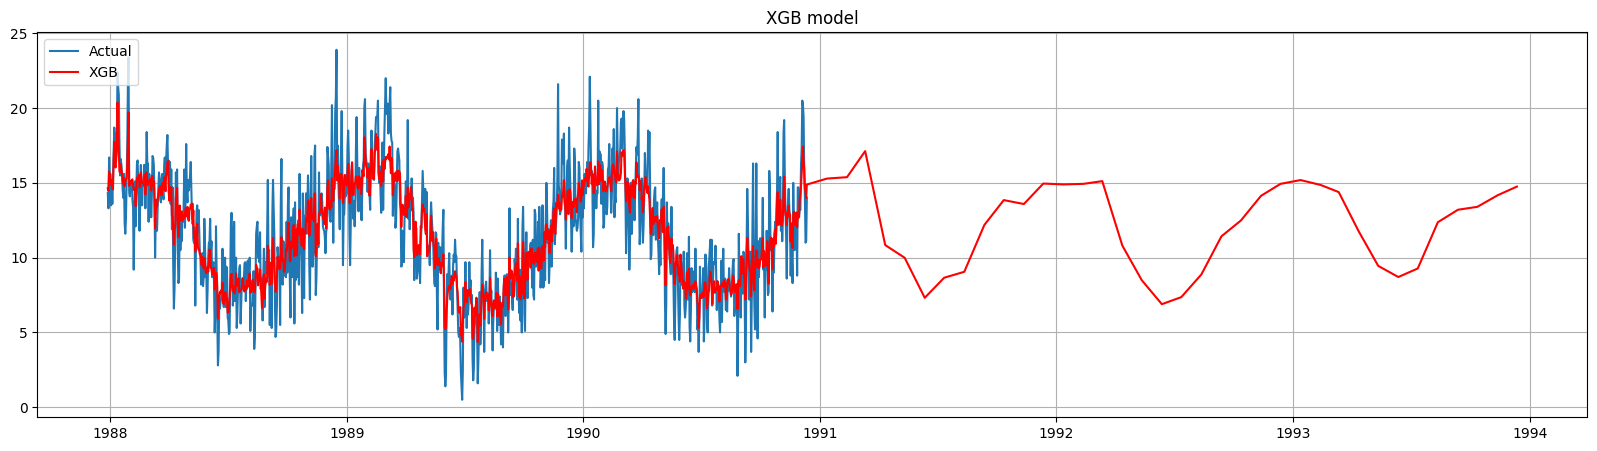

In [34]:
plt.figure(figsize=(20, 5))
plt.title("XGB model")
plt.plot(extended_df['temp'], label="Actual")
plt.plot(extended_df['xgb_result'], "r", label="XGB")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()